In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
def preprocess_image_train(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = applications.mobilenet_v2.preprocess_input(image)
    return image, label

def preprocess_test_val_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = applications.mobilenet_v2.preprocess_input(image)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.map(preprocess_test_val_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(preprocess_test_val_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


170498071/170498071 [==============================] - 5s 0us/step


In [3]:
# MobileNetV2 # layer_count = 30 , drop_out = 0.5 , learning_rate = 1e-4
base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

layer_count = 30
for layer in base_model.layers[:layer_count*(-1)]:
    layer.trainable = False

drop_out = 0.5
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(drop_out),
    layers.Dense(10, activation='softmax')
])

print(model.summary())

learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                           

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [5]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


157/157 [==============================] - 11s 68ms/step
Precision: 0.9153
Recall: 0.9139
F1-score: 0.9134


In [6]:
# MobileNetV2 # layer_count = 60 , drop_out = 0.3 , learning_rate = 1e-4
base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

layer_count = 60
for layer in base_model.layers[:layer_count*(-1)]:
    layer.trainable = False

drop_out = 0.3
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(drop_out),
    layers.Dense(10, activation='softmax')
])

print(model.summary())

learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2588490 (9.87 MB)
Trainable params: 2286

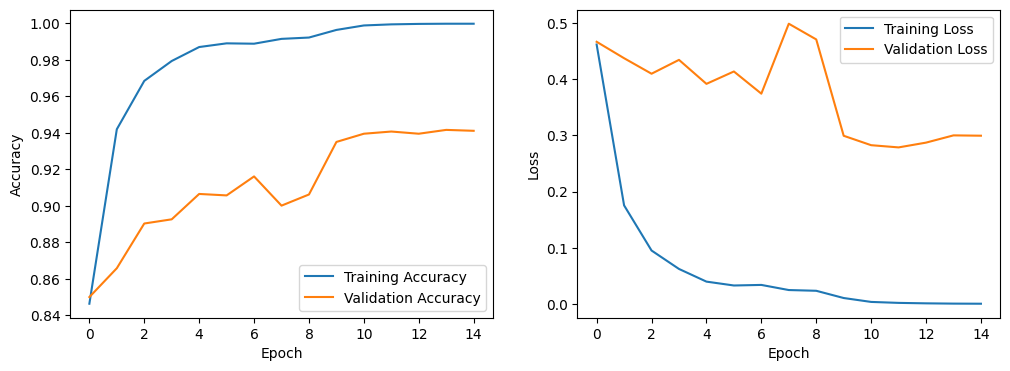

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


157/157 [==============================] - 11s 67ms/step
Precision: 0.9376
Recall: 0.9375
F1-score: 0.9375
